# Lab4 - Mushroom Classification
Author: Michael Metz


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


We are going to follow the grid-search workflow: 
- Split data into training and test set,
- Use the training portion to find the best model using grid search and cross-validation,
- Retrain the best model,
- Evaluate the retrained model on the test set.

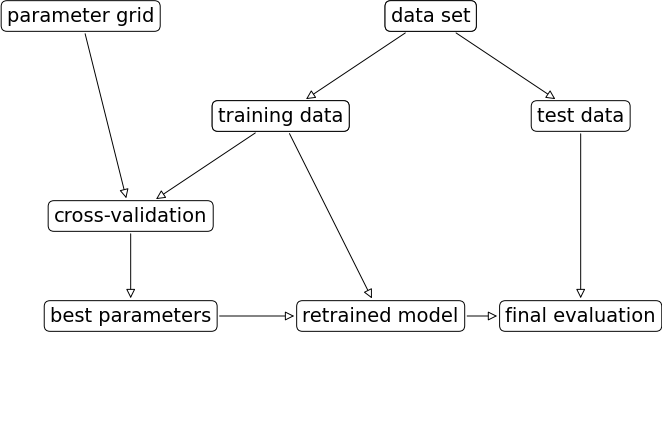

In [2]:
import mglearn
mglearn.plots.plot_grid_search_overview()


## 0. Function definitions

In [3]:
from sklearn.model_selection import cross_validate


def get_classifier_cv_score(model, X, y, scoring='accuracy', cv=7):
    '''Calculate train and validation scores of classifier (model) using cross-validation


        model (sklearn classifier): Classifier to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        scoring (str): a scoring string accepted by sklearn.metrics.cross_validate()
        cv (int): number of cross-validation folds see sklearn.metrics.cross_validate()

        returns: mean training score, mean validation score
    '''

     # TODO: implement function body

    score_dict = cross_validate(
        model, X, y, scoring=scoring, cv=cv, return_train_score=True)

    return score_dict["train_score"].mean(), score_dict["test_score"].mean()


In [4]:
def print_grid_search_result(grid_search):
    '''Prints summary of best model from GridSearchCV object.

        For the best model of the grid search, print:
        - parameters 
        - cross-validation training score
        - cross-validation validation score 

        scores are printed with 3 decimal places.

        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object

        returns: None

    '''

    print(grid_search.best_params_)
    print("training score= {:.3f}; validation score={:.3f}".format(
        grid_search.cv_results_['mean_train_score'][grid_search.best_index_],
        grid_search.cv_results_['mean_test_score'][grid_search.best_index_]))


In [5]:
import mglearn


def plot_grid_search_results(grid_search):
    '''For grids with 2 hyperparameters, create a heatmap plot of test scores

        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object

        uses mglearn.tools.heatmap() for plotting.

    '''
    results = pd.DataFrame(grid_search.cv_results_)

    params = sorted(grid_search.param_grid.keys())

    assert len(params) == 2, "We can only plot two parameters."

    # second dimension in reshape are columns in a row, needs to be the fast changing parameter
    scores = np.array(results.mean_test_score).reshape(
        len(grid_search.param_grid[params[0]]),
        len(grid_search.param_grid[params[1]]))

    # plot the mean cross-validation scores
    # x-axis needs to be the fast changing parameter
    mglearn.tools.heatmap(
        scores,
        xlabel=params[1],
        xticklabels=grid_search.param_grid[params[1]],
        ylabel=params[0],
        yticklabels=grid_search.param_grid[params[0]],
        cmap="viridis", fmt="%0.3f")


In [6]:
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_actual, y_pred, labels, title=''):
    '''Creates a heatmap plot of the confusion matrix.

        y_actual (pandas.DataSeries or numpy.Array): Ground truth label vector
        y_pred (pandas.DataSeries or numpy.Array): Predicted label vector
        labels (list(str)): Class names used for plotting (ticklabels)
        title (str): Plot title

        uses sklearn.metrics.confusion_matrix

    '''

    mat = confusion_matrix(y_actual, y_pred)

    sns.heatmap(
        mat,
        xticklabels=labels,
        yticklabels=labels,
        square=True, annot=True, cbar=False,
        fmt='d')
    plt.xlabel('predicted value')
    plt.ylabel('true value')
    plt.title(title)


## 1. Load data
yellowbrick mushroom  
https://www.scikit-yb.org/en/latest/api/datasets/mushroom.html




### 1.1 Prepare the feature matrix and target vector

Using the yellowbrick `load_mushroom()` function, load the mushroom data set into feature matrix `X` and target vector `y`.

Print shape and type of `X`, `y`.

In [7]:
# TODO: add data loading code
from yellowbrick.datasets import load_mushroom

X, y = load_mushroom()

print("X:",X.shape, type(X))
print("y:",y.shape, type(y))

X: (8123, 3) <class 'pandas.core.frame.DataFrame'>
y: (8123,) <class 'pandas.core.series.Series'>


## 2. Inspect the data 

### 2.1 Relationship between features and target classes
The mushroom dataset is composed of three categorical features and one binary target.

To understand the relationship between categorical features and target classes better, it is usefull to create barplots. Using seaborn `countplot()`, create a barplot for each of the three feature columns in `X` using  `y` as hue.

<AxesSubplot:xlabel='color', ylabel='count'>

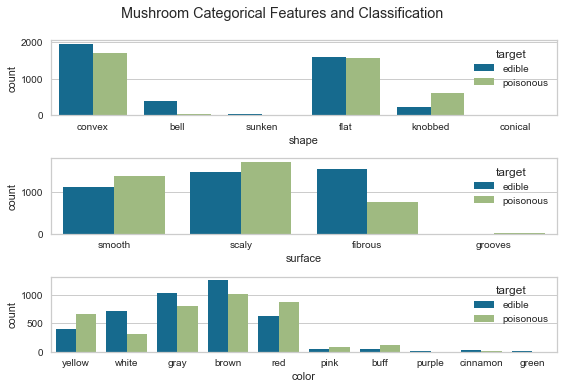

In [133]:
# TODO: Add countplots for each feature.

fig, axs = plt.subplots(3, 1)

# x labels get hidden behind the other subplots otherwise.
# Also set_layout_engine wasn't working for the fig object for some reason.
fig.set_tight_layout(True)

fig.suptitle("Mushroom Categorical Features and Classification")

sns.countplot(x=X["shape"], hue=y, ax=axs[0])
sns.countplot(x=X["surface"], hue=y, ax=axs[1])
sns.countplot(x=X["color"], hue=y, ax=axs[2])


## 3. Preprocessing
In this dataset, all features are discrete and nominal and need to be encoded. We will use a `OneHotEncoder`.

The target vector is discrete and nominal as well and contains string labels. While sklearn is OK using string labels in target vectors, you will use a `LabelEncoder` explicitly to convert strings to integers and keep the encoder to translate between the two representations.

### 3.1 Onehot encoding of features
Use `OneHotEncoder` to convert `X` into one-hot-encoded features stored in a varible `X_enc`. Use `spares=False`. Print shape of `X_enc`.

In [114]:
# TODO: add OneHotEncoder here
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)

enc.fit(X)

X_enc = pd.DataFrame(enc.transform(X), columns=enc.get_feature_names_out())
X_enc.shape

X_enc

,shape_bell,shape_conical,shape_convex,shape_flat,shape_knobbed,shape_sunken,surface_fibrous,surface_grooves,surface_scaly,surface_smooth,color_brown,color_buff,color_cinnamon,color_gray,color_green,color_pink,color_purple,color_red,color_white,color_yellow
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8119,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8120,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8121,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.2 Label encode target vector 
Use `LabelEncoder` to encode the target vector `y`, saved in a varibale `y_enc`.

Print the resulting target vector `y_enc` and print the class names available in the `classes_` attribute of the `LabelEncoder` object.

In [144]:
# TODO: add LabelEncoder here
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()

enc.fit(y)

y_enc = pd.Series(enc.transform(y), name=y.name + "_enc")

print("encoded target", y_enc.to_numpy())
print("classes", enc.classes_)

encoded target [0 0 1 ... 0 1 0]
classes ['edible' 'poisonous']


### *Question 1:* How are class label strings mapped to integers? Show an example for both.
Hint: use `transform()` or `inverse_transform()` method of the `LabelEncoder` object.

In [143]:
y_enc_arr = enc.transform(y)
y_arr = enc.inverse_transform(y_enc_arr)

print(y_enc_arr)
print(y_arr)

[0 0 1 ... 0 1 0]
['edible' 'edible' 'poisonous' ... 'edible' 'poisonous' 'edible']


Class label strings are mapped to integers by mapping `edible` to `0` and `poisonous` to `1`. This is seen above when we transform `y` and then inverse transform `y_enc_arr` and compare the results one on top of the other.

## 4. Create training and test sets
Using scikit-learn `train_test_split()` with parameters `random_state=37`, `test_size=0.2`, split `X_enc` and `y_enc` into training and test sets.

In [13]:
# TODO: add train_test_split() here


## 5. Compare models using cross-validation
Create a list containing a `LogisticRegression()`, 
          `SVC()`,
          `BernoulliNB()`,
        `RandomForestClassifier(random_state=55)`, 
         `GradientBoostingClassifier(random_state=56)` objects.

Iterate this list, then:
- compute the **f1 score** using `get_classifier_cv_score()` with 7-fold cross-validation defined above, 
- using `X_train` and `y_train` as arguments,
- rank the models based on validation **f1 score** (best first),
- and print the ranked models training and validation scores with **3 decimal places**. 

In [14]:
# TODO: add cross-validation comparison here


Sorted by validation score
1. GradientBoostingClassifier(random_state=56) train_score=0.702 validation_score=0.692
2. SVC() train_score=0.691 validation_score=0.678
3. RandomForestClassifier(random_state=55) train_score=0.692 validation_score=0.678
4. LogisticRegression() train_score=0.663 validation_score=0.664
5. BernoulliNB() train_score=0.614 validation_score=0.613


## 6. Hyperparameter tuning using grid search 

The inital cross-validation above gives us an idea of how algorithms perfom using their default hyperparameters.

Next, we will try and improve one model by tuning its hyperparameters using grid search.

### 6.1 Grid search for RandomForestClassifier 

Perform grid search using `GridSearchCV` for the `RandomForestClassifier(n_estimators=300, random_state=55)`:

- Set the number of trees `n_estimators=300` for all evaluations,
- Grid search to use 7-fold cross-validation, 
- and `f1` as the scoring function. 
- Note that there is a `n_jobs` parameter to run search in parallel. Setting it to the number of CPU cores  or -1 works well.

Use the following hyperparameters and values:
- `'max_depth': [3, 5, 8]`
- `'max_features': [0.3, 0.5, 0.7, 0.9]`

From sklearn help:
> - max_depth: The maximum depth of the tree.
> - max_features: If float, then max_features is a fraction and max(1, int(max_features * n_features_in_)) features are considered at each split.


Use `print_grid_search_result()` and `plot_grid_search_result()` functions defined above to show the results.

In [15]:
# TODO: Setup grid search for RandomForestClassifier(random_state=55)


In [16]:
# TODO: perform the grid search by calling fit() with X_train and y_train


GridSearchCV(cv=7,
             estimator=RandomForestClassifier(n_estimators=300,
                                              random_state=55),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 8],
                         'max_features': [0.3, 0.5, 0.7, 0.9]},
             return_train_score=True, scoring='f1')

In [17]:
# TODO: call print_grid_search_result() to print the results


{'max_depth': 5, 'max_features': 0.7}
training score= 0.719; validation score=0.716


### *Question 3:* What is the validation score of the best model? Which models in Section 5 does it outperform?

*ADD YOUR ANSWER HERE*


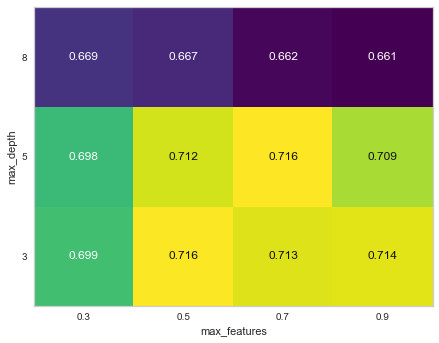

In [18]:
# TODO: call plot_grid_search_results() to plot validation metrics for all hyperparameter combinations


### *Question 4:* Where in the hyper-parameter ranges does the maximum occur? Would you need to adjust the hyper-paramter ranges to find a better model?

*ADD YOUR ANSWER HERE*


## 7. Retrain best model
Retrain the best `RandomForestClassifier()` from the grid search above on the training dataset `X_train` and `y_train`.

In [19]:
#TDOD: Retrain best random forest classifier


RandomForestClassifier(max_depth=5, max_features=0.7, n_estimators=300,
                       random_state=55)
{'max_depth': 5, 'max_features': 0.7}


## 8. Evaluate on test data

Using the retrained model and the test dataset `X_test` and `y_test`:
- plot the confusion matrix using the `plot_confusion_matrix()` function defined above
- print the classification report

Make sure the plot has class labels and a title.

### 8.1 Confusion matrix and classification report

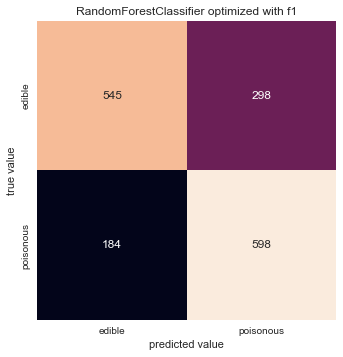

In [20]:
#TODO: call plot_confusion_matrix(), use LabelEncoder classes_ to get labels


In [21]:
#TODO: print classification report using default threshold


              precision    recall  f1-score   support

           0       0.75      0.65      0.69       843
           1       0.67      0.76      0.71       782

    accuracy                           0.70      1625
   macro avg       0.71      0.71      0.70      1625
weighted avg       0.71      0.70      0.70      1625



### *Question 5:* What are the precision, recall and accuracy for the positive class on the test set?

*ADD YOUR ANSWER HERE*


### *Question 6:* How many false negatives and false positives does the model produce on the test set?

*ADD YOUR ANSWER HERE*


## 9. Conclusion

In conclusion, comment on the following items and use data to support your findings:
1. In the classification of edible vs poisonous mushrooms, what do false positive and false negative predictions imply and what are the consequences of making these mistakes?
1. In the classification of edible vs poisonous mushrooms, why is high recall desired?
1. Reflect on the usefulness of this model if it would be put into production and propose ways to improve the model and/or application.

*YOUR ANSWER HERE*




## 10. Reflection
Include a sentence or two about:
- what you liked or disliked,
- found interesting, confusing, challangeing, motivating while working on this assignment.

*ADD YOUR THOUGHTS HERE*



## Appendix A: Optional work

Ideas for optional investigations:
1. Could we boost performance using feature engineering?
1. Use a different metric to find the best model
1. Grid search for other classifiers
1. Find a better threshold
